In [1]:
import os
import sys
import time
import glob
import datetime
import sqlite3
import numpy as np
import compress_feat as CBTF 
import randproj as RANDPROJ
import matplotlib.pyplot as plt
import copy
import seaborn as sb
msd_subset_path='/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/'
msd_subset_data_path='/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C'
msd_subset_addf_path=os.path.join(msd_subset_path,'helpers')
msd_code_path='/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/helpers'
sys.path.append(os.path.join(msd_code_path,'PythonSrc') )
import hdf5_getters as GETTERS

In [2]:
def get_time_warp_matrix(segstart, btstart, duration):
    """
    Used by create_beat_synchro_chromagram
    Returns a matrix (#beats,#segs)
    #segs should be larger than #beats, i.e. many events or segs
    happen in one beat.
    THIS FUNCTION WAS ORIGINALLY CREATED BY RON J. WEISS (Columbia/NYU/Google)
    """
    # length of beats and segments in seconds
    # result for track: 'TR0002Q11C3FA8332D'
    #    seglen.shape = (708,)
    #    btlen.shape = (304,)
    #    duration = 238.91546    meaning approx. 3min59s
    seglen = np.concatenate((segstart[1:], [duration])) - segstart
    btlen = np.concatenate((btstart[1:], [duration])) - btstart

    warpmat = np.zeros((len(segstart), len(btstart)))
    # iterate over beats (columns of warpmat)
    for n in range(len(btstart)):
        # beat start time and end time in seconds
        start = btstart[n]
        end = start + btlen[n]
        # np.nonzero returns index of nonzero elems
        # find first segment that starts after beat starts - 1
        try:
            start_idx = np.nonzero((segstart - start) >= 0)[0][0] - 1
        except IndexError:
            # no segment start after that beats, can happen close
            # to the end, simply ignore, maybe even break?
            # (catching faster than ckecking... it happens rarely?)
            break
        # find first segment that starts after beat ends
        segs_after = np.nonzero((segstart - end) >= 0)[0]
        if segs_after.shape[0] == 0:
            end_idx = start_idx
        else:
            end_idx = segs_after[0]
        # fill col of warpmat with 1 for the elem in between
        # (including start_idx, excluding end_idx)
        warpmat[start_idx:end_idx, n] = 1.
        # if the beat started after the segment, keep the proportion
        # of the segment that is inside the beat
        warpmat[start_idx, n] = 1. - ((start - segstart[start_idx])
                                 / seglen[start_idx])
        # if the segment ended after the beat ended, keep the proportion
        # of the segment that is inside the beat
        if end_idx - 1 > start_idx:
            warpmat[end_idx-1, n] = ((end - segstart[end_idx-1])
                                     / seglen[end_idx-1])
        # normalize so the 'energy' for one beat is one
        warpmat[:, n] /= np.sum(warpmat[:, n])
    return warpmat.T
# path to the Million Song Dataset subset (uncompressed)
def get_bttimbre(h5):
    """
    Get beat-aligned timbre from a song file of the Million Song Dataset
    INPUT:
       h5          - filename or open h5 file
    RETURN:
       bttimbre    - beat-aligned timbre, one beat per column
                     or None if something went wrong (e.g. no beats)
    """    
    timbre = GETTERS.get_segments_timbre(h5)
    segstarts = GETTERS.get_segments_start(h5)
    btstarts = GETTERS.get_beats_start(h5)
    duration = GETTERS.get_duration(h5)
    # get the series of starts for segments and beats
    # NOTE: MAYBE USELESS?
    # result for track: 'TR0002Q11C3FA8332D'
    #    segstarts.shape = (708,)
    #    btstarts.shape = (304,)
    segstarts = np.array(segstarts).flatten()
    btstarts = np.array(btstarts).flatten()
    # aligned features
    bttimbre = align_feats(timbre.T, segstarts, btstarts, duration)
    if bttimbre is None:
        return None
    # done (no renormalization)
    return bttimbre
def get_btloudness(h5):
    loudness = np.array([GETTERS.get_segments_loudness_max(h5)])
    segstarts = GETTERS.get_segments_start(h5)
    btstarts = GETTERS.get_beats_start(h5)
    duration = GETTERS.get_duration(h5)
    segstarts = np.array(segstarts).flatten()
    btstarts = np.array(btstarts).flatten()
    btloudness = align_feats(loudness,segstarts, btstarts, duration)
    if btloudness is None:
        return None
    # done (no renormalization)
    return btloudness
def align_feats(feats, segstarts, btstarts, duration):
    """
    MAIN FUNCTION: aligned whatever matrix of features is passed,
    one column per segment, and interpolate them to get features
    per beat.
    Note that btstarts could be anything, e.g. bar starts
    INPUT
       feats      - matrix of features, one column per segment
       segstarts  - segments starts in seconds,
                    dim must match feats # cols (flatten ndarray)
       btstarts   - beat starts in seconds (flatten ndarray)
       duration   - overall track duration in seconds
    RETURN
       btfeats    - features, one column per beat
                    None if there is a problem
    """
    # sanity check
    if feats.shape[0] == 0 or feats.shape[1] == 0:
        return None
    if btstarts.shape[0] == 0 or segstarts.shape[0] == 0:
        return None

    # FEAT PER BEAT
    # Move segment feature onto a regular grid
    # result for track: 'TR0002Q11C3FA8332D'
    #    warpmat.shape = (304, 708)
    #    btchroma.shape = (304, 12)
    warpmat = get_time_warp_matrix(segstarts, btstarts, duration)
    featchroma = np.dot(warpmat, feats.T).T
    if featchroma.shape[1] == 0: # sanity check
        return None
    # done
    return featchroma


def get_bttatums(h5):
    tatums = GETTERS.get_tatums_start(h5)
    segstarts = GETTERS.get_segments_start(h5)
    btstarts = GETTERS.get_beats_start(h5)
    duration = GETTERS.get_duration(h5)
    btstarts = np.array(btstarts).flatten()
    numbt = btstarts.shape[0]
    bttatums = np.zeros(numbt)
    i,j = 0,0
    while i < len(tatums):
        while j < len(btstarts) and btstarts[j] < tatums[i] :
            j+=1
        if j < len(btstarts):
            bttatums[j] +=1 
        i += 1
    if bttatums is None:
        return None
    return np.array([bttatums])

(1549, 12) (1549, 12)


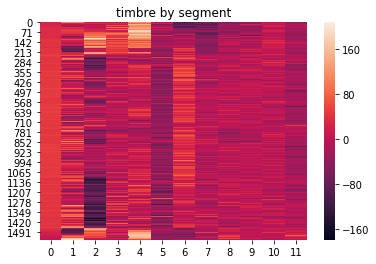

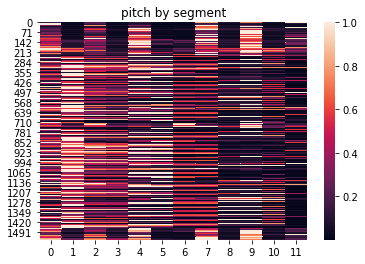

(365, 1549)


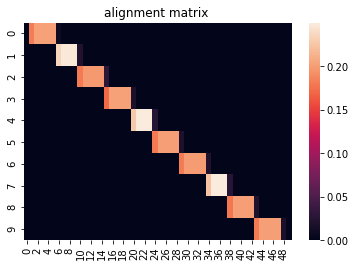

(12, 365)


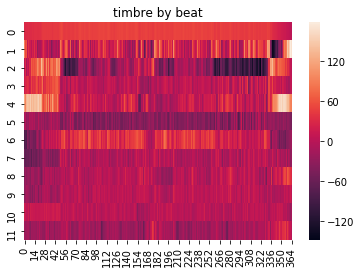

In [ ]:
sample_h5 = '/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/G/Y/TRCGYMC12903CA5752.h5'
h5 = GETTERS.open_h5_file_read(sample_h5)
timbre = GETTERS.get_segments_timbre(h5)
pitch = GETTERS.get_segments_pitches(h5)
segstarts = GETTERS.get_segments_start(h5)
btstarts = GETTERS.get_beats_start(h5)
duration = GETTERS.get_duration(h5)

bttimbre = get_bttimbre(h5)
h5.close()
print(timbre.shape, pitch.shape)
fig = plt.gcf()
sb.heatmap(timbre)
plt.title('timbre by segment')
plt.show()
sb.heatmap(pitch)
plt.title('pitch by segment')
plt.show()

warpmat = get_time_warp_matrix(segstarts, btstarts, duration)
print(warpmat.shape)
sb.heatmap(warpmat[0:10,0:50])
plt.title('alignment matrix ')
plt.show()

print(bttimbre.shape)
sb.heatmap(bttimbre)
plt.title('timbre by beat')
plt.show()

In [ ]:
def getSamples(basedir):
    X, Y = [],[]
    feature_labels = ['segments_pitch', 
                 'segments_timbre',
                 'segments_loudness_max',
                 'tempo']
    cnt = 0
    for root, dirs, files in os.walk(basedir):
        files = glob.glob(os.path.join(root,'*.h5'))
        print(root, cnt)
        # apply function to all files
        for f in files :
#             try:
            h5 = GETTERS.open_h5_file_read(f)
#                 segments_pitch = GETTERS.get_segments_pitches(h5)
#                 segments_timbre = GETTERS.get_segments_timbre(h5)
#                 segments_loudness_max = GETTERS.get_segments_loudness_max(h5)
#                 tempo = GETTERS.get_tempo(h5)
#             except:
#                 h5.close()
#                 print('error')
#                 continue
            year = GETTERS.get_year(h5)
            time_sig = GETTERS.get_time_signature(h5)
        
            if year == 0:
                continue
            bttimbre = get_bttimbre(h5)
            bttatums = get_bttatums(h5)
            btloudness = get_btloudness(h5)
            h5.close()
            if bttimbre is None or bttatums is None or year == 0 or get_btloudness is None:
                continue
            X.append([bttimbre,bttatums,time_sig,btloudness])
            Y.append(year)
            cnt+=1
            if cnt  > 10000:
                break;
    return X, Y, feature_labels

X, Y, labels = getSamples(msd_subset_data_path)

/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C 0
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/R 0
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/R/R 0
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/R/U 30
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/R/I 63
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/R/N 103
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/R/G 127
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/R/Z 156
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/R/T 183
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/R/S 216
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/R/A 242
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/R/F 284
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/R/O 325
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/R/H 361
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/R/M 401
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/

/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/Z/U 3675
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/Z/I 3701
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/Z/N 3751
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/Z/G 3768
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/Z/Z 3800
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/Z/T 3828
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/Z/S 3863
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/Z/A 3899
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/Z/F 3923
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/Z/O 3953
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/Z/H 3980
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/Z/M 4010
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/Z/J 4048
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/Z/C 4075
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/Z/D 4110
/Users/sw_k_jung/Google D

In [ ]:
print(len(X), len(Y))

1399 1399
{2000: 824, 1990: 343, 1980: 99, 1970: 75, 1960: 34, 1950: 8, 2010: 16}


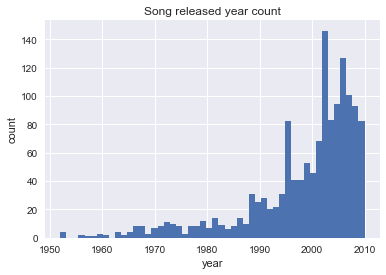

In [260]:

# Generate a normal distribution, center at x=0 and y=
X_filtered = []
Y_filtered = []
decades= dict()
for i, year in enumerate(Y):
    if year >= 1940:
        decade = year-(year%10)
        X_filtered.append(X[i])
        Y_filtered.append(Y[i])
        if decade not in decades:
            decades[decade] = 1
        else:
            decades[decade] +=1
print(len(X_filtered),len(Y_filtered))
print(decades)
plt.hist(Y_filtered, bins=50)
plt.xlabel('year')
plt.ylabel('count')
plt.title('Song released year count')
plt.show()


In [249]:
def extract_and_compress(btfeat, npicks, winsize, finaldim, seed=3232343, randproj=None):
    """
    From a btfeat matrix, usually 12xLENGTH
    Extracts 'npicks' windows of size 'winsize' equally spaced
    Flatten these picks, pass them through a random projection, final
    size is 'finaldim'
    Returns matrix npicks x finaldim, or 0 x finaldim if problem
    (btfeats not long enough for instance)
    We could return less than npicks if not long enough!
    For speed, we can compute the random projection once and pass it as an
    argument.
    """
    # features length
    ftlen = btfeat.shape[1]
    ndim = btfeat.shape[0]
    # too small case
    if ftlen < winsize:
        return np.zeros((0, finaldim))
    # random projection
    if randproj is None:
        randproj = RANDPROJ.proj_point5(ndim * winsize, finaldim, seed=seed)
    # not big enough for number of picks, last one too large return just 1
    if ftlen < int(ftlen * (npicks * 1. / (npicks + 1))) + winsize:
        pos = int((ftlen - winsize) / 2.)  # middle
        picks = [btfeat[:, pos:pos + winsize]]
    # regular case, picks will contain npicks
    else:
        picks = []
        for k in range(1, npicks + 1):
            pos = int(ftlen * (k * 1. / (npicks + 1)))
            picks.append(btfeat[:, pos:pos + winsize])

    # project / compress these
#     projections = list(map(lambda x: np.dot(x.flatten(), randproj).reshape(1, finaldim), picks))
    projections = list(map(lambda x: np.mean(x, axis = 1).reshape(1, ndim), picks))
    return np.concatenate(projections)

def flatten(X,Y, npicks = 3, winsize = 12, finaldim = 5):
    flattenedX,flattenedY = [],[]
    for i in range(len(X)):
#     for i in range(1):
        x = X[i]
        bttimbre = x[0]
        bttatums = x[1] # ndarray 1 x numbt 
        time_sig = x[2]
        ndim_timbre = bttimbre.shape[0]
        ndim_tatum = bttatums.shape[0]
        numbt = bttatums.shape[1]
        if time_sig is not None:
            winsize = time_sig
            npicks = int(numbt/winsize)
        randproj_timbre = RANDPROJ.proj_point5(ndim_timbre * winsize, finaldim)
#         randproj_tatum = RANDPROJ.proj_point5(ndim_tatum * winsize, finaldim)
        if numbt > npicks:
            processed_timbre = extract_and_compress(bttimbre,npicks,winsize,finaldim,randproj=randproj_timbre)
#             print(processed_timbre.shape)
#             processed_tatum = extract_and_compress(bttatums,npicks,winsize,finaldim,randproj=randproj_tatum)
            processed_feats = []
            for n in range(processed_timbre.shape[0]):
                processed_feats.append(processed_timbre[n])
#                 processed_feats.append(np.concatenate((processed_timbre[n], processed_tatum[n]), asxis=None))
            flattenedX =flattenedX+processed_feats
            flattenedY = flattenedY+processed_timbre.shape[0]*[Y[i]]
    return flattenedX, flattenedY

In [248]:
### from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
error1, error2 = [], []
for p in range(1, 200 , 10):
    X_flattened,Y_flattened = flatten(X_filtered, Y_filtered, npicks=p) 
    X_train, X_test, y_train, y_test = train_test_split(X_flattened, Y_flattened, test_size=0.2, random_state=42)
    print(np.mean(y_test))
    print('train num', len(y_train), 'test num', len(y_test))

    regr =linear_model.LinearRegression()
    regr.fit(X_train,y_train)
    regr_predict = regr.predict(X_test)
    error  = np.mean(np.abs(y_test - regr_predict))
    error1.append(error)
    print('linear model', error, np.mean(regr_predict) ,np.std(regr_predict))

    knn = KNeighborsClassifier(n_neighbors=50)
    knn.fit(X_train, y_train)
    predicted_years = knn.predict(X_test)
    error  = np.mean(np.abs(y_test - predicted_years))
    error2.append(error)
    print('50 knn', error, np.mean(predicted_years),np.std(predicted_years))

KeyboardInterrupt: 

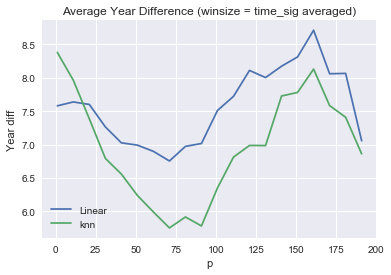

In [233]:
sb.set()
error_linear_winsize = [8.214812908492902, 8.15227288170814, 8.75227288170814, 8.333040678189397, 8.185774048725843, 8.151514970773299, 8.020925244831949, 8.120925244831949]
error_knn_picks = [8.11595639246779, 9.21543461955163, 9.258599963010912, 7.959596288458408, 7.717626463210703, 8.049918034679411, 7.523256070884062, 8.812385580291558, 7.702863873960097, 7.167771141836429, 7.125482745733151, 8.413603337889361, 8.878461602915916, 9.241271393643032, 9.009551590025167, 7.918245980917527, 7.04178421654594, 8.45604683677036, 6.9941921355803105, 8.161047027506655]
error_linear_timbre_tatum = [7.35756079, 7.3006048,7.25981149,7.138917730,7.0551099132,7.013456, 7.01313604411, 6.99913799, 6.99193470, 6.9965110]
error_knn_timbre_tatum = [7.635065134, 6.959632183, 6.55846743, 6.18620689, 6.1499157088, 6.1336091954, 6.01063601, 6.08429118, 5.9637088122, 5.955800766]
# plt.plot(np.arange(1, 100,5), error1)
plt.plot(np.arange(1, 200 , 10), error1, label = 'Linear')
plt.plot(np.arange(1, 200 , 10), error2, label= 'knn')
# plt.plot(np.arange(1, 100,10), error_linear_timbre_tatum, label = 'Timbre+Tatum (Linear)')
# plt.plot(np.arange(1, 100,10), error_knn_timbre_tatum, label= 'Timbre+Tatum (knn)')
plt.legend()
plt.xlabel('p')
plt.ylabel('Year diff')
plt.title(r'Average Year Difference (winsize = time_sig averaged)')
plt.show()

In [128]:
print(error1)

[8.214812908492902, 8.15227288170814, 150848489152.68402, 8.333040678189397, 8.185774048725843, 8.151514970773299, 8.020925244831949, 634942741654.5823]


In [473]:
def extract_and_avg(x, npicks, winsize, finaldim, seed=3232343, randproj=None):
    # features length  
    bttimbre = x[0]
    bttatums = x[1] # ndarray 1 x numbt 
    time_sig = x[2]
    btloudness = x[3]
    ftlen = bttimbre.shape[1]
    ndim = bttimbre.shape[0]
    # too small case
    if ftlen < winsize:
        return None
#         return np.zeros((0, finaldim))
    if ftlen < int(ftlen * (npicks * 1. / (npicks + 1))) + winsize:
#         pos = int((ftlen - winsize) / 2.)  # middle
#         picks = [bttimbre[:, pos:pos + winsize]]
        return None
    # regular case, picks will contain npicks
    else:
        picks = []
        for k in range(1, npicks + 1):
            pos = int(ftlen * (k * 1. / (npicks + 1)))
            bttimbre_window = bttimbre[:, pos:pos + winsize]
            bttatums_window = bttatums[:, pos:pos + winsize]
            btloudness_window = btloudness[:, pos:pos + winsize]
            feat_concat = np.concatenate((bttimbre_window,bttatums_window,btloudness_window))
            picks.append(feat_concat)
#     picks = np.array(picks)
    return picks

def flatten_cov(X,Y, npicks = 75, winsize = 4, finaldim = 5):
    flattenedX,flattenedY = [],[]
    for i in range(len(X)):
        x = X[i]
#         time_sig = x[2]
#         if time_sig is not None:
#             winsize = time_sig
        processed_feats = extract_and_avg(x,npicks,winsize,finaldim)
        if processed_feats is not None:
            flattenedX += processed_feats
            flattenedY += len(processed_feats[Y[i]]
    return flattenedX, flattenedY


In [442]:
from sklearn.neural_network import MLPClassifier
X_flattened,Y_flattened = flatten(X_filtered, Y_filtered) 
print(np.array(X_flattened).shape)
X_train, X_test, y_train, y_test = train_test_split(X_flattened, Y_flattened, test_size=0.2, random_state=42)
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(X_train, y_train)                         
predicted_years = clf.predict(X_test)
error  = np.mean(np.abs(y_test - predicted_years))
print(error)

KeyboardInterrupt: 

In [474]:
X_flattened,Y_flattened = flatten_cov(X_filtered, Y_filtered) 
X_train, X_test, y_train, y_test = train_test_split(X_flattened, Y_flattened, test_size=0.2, random_state=42)
print(len(X_train), len(y_train))
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
class Net(nn.Module):
    def __init__(self, num_classes=1):
        super(Net, self).__init__()
        self.c1 = nn.Conv1d(14, 75, 2)
        self.c2 = nn.Conv1d(75, 10, 2)
        self.p1 = nn.AvgPool1d(2)
        self.fc = nn.Linear(10, 1)
    def forward(self, x):
        out = self.c1(x)
        out = self.c2(x)
        out = self.p1(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out
    
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(net.parameters() ,lr = 0.001)
inputs = Variable(torch.from_numpy(np.array(X_train)).float())
test_inputs = Variable(torch.from_numpy(np.array(X_test)).float())
targets = Variable(torch.from_numpy(np.array([y_train]).T).float())
test_targets= Variable(torch.from_numpy(np.array([y_test]).T).float())
running_loss = 0.0
loss_train_list = []
loss_test_list = []

for epoch in range(200):  # loop over the dataset multiple times
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = torch.mean(torch.abs(outputs+1940 - targets))
    loss.backward()
    optimizer.step()
    outputs_test = net(test_inputs)
    loss_test = torch.mean(torch.abs(outputs_test+1940 - test_targets))
    loss_train_list.append(loss.item())
    loss_test_list.append(loss_test.item())
    if(epoch+1)%5 ==0:
        print('Epoch [%d] , Loss : %.4f'%(epoch+1 , loss.data[0]))

ValueError: operands could not be broadcast together with shapes (0,) (75,14,4) 

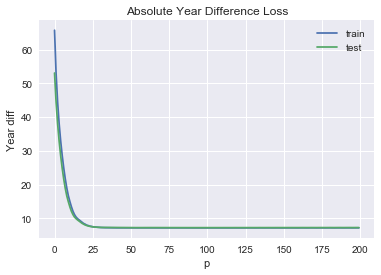

7.263713836669922


In [471]:
plt.plot(np.arange(0, 200 , 1), loss_train_list, label = 'train')
plt.plot(np.arange(0, 200 , 1), loss_test_list, label= 'test')
plt.legend()
plt.xlabel('p')
plt.ylabel('Year diff')
plt.title(r'Absolute Year Difference Loss')
plt.show()
print(min(loss_test_list))